In [1]:
from toolz import valmap

import h5py
import pyharm

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm
import pyharm.plots.plot_dumps as pplt

from mpl_toolkits import mplot3d

In [2]:
i0 = 5010 # initial  frame
i1 = 5061 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [3]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16
mu = 1.

In [4]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [5]:
src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

dump0 = pyharm.load_dump(fname(i0, src_ma_10M))
R_low = 1.
R_high = [1, 10, 40, 160]
# first row of SANE model params

In [6]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

for later variance($\rho$|$P_{g}$|$P_{mag}$) calculations

In [7]:
def average(irange, dumps, keys):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [8]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps, quality='Te'):
    """
    quality: str, the physical quality whose variance values we want (e.g. 'Te' for electron temperature)
    dumps: dictionary, all the dump files read in
    """
    key = 'var' + quality
    ss = {key: 0}
    for i in irange:
        d = dumps[str(i)].cache
        ss[key] += (d[quality]-d['avg' + quality])**2
    for i in irange:
        dumps[str(i)].cache[key] = ss[key]
    print('finish variance & standard deviation calculation\'s loop.')
    # return valmap(lambda v: v/len(irange), ss)

$\gamma = \frac{4}{3}$, $x_{e} = \frac{1}{4}$, so ions:electrons = 3:1 (y=1, z=3; $\gamma_{i}=\gamma=\frac{4}{3}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{7}{3}$) <br> 
$Const = m_{p}(\gamma_{e}-1)(\gamma_{i}-1)$ <br> 
$const1 = y(\gamma_{i}-1)$ <br>
$const2 = z(\gamma_{e}-1)$ <br>
$const3 = k_{B}(\gamma-1)$

In [9]:
# constants used for the functions
y = 1.
z = 3.
gamma = 4/3
gamma_i = 4/3
gamma_e = 7/3
const = mp*(gamma_e - 1)*(gamma_i - 1)
const1 = y*(gamma_i - 1)
const2 = z*(gamma_e - 1)
const3 = kb*(gamma - 1)

$R=\frac{R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{R_{high}P_{g}^{2}}{P_{mag}^{2}+P_{g}^{2}}$

In [10]:
def R(dump, Rh, Rl, Pmag):
    Pg = dump['Pg']
    return Rl/(Pmag**2+Pg**2)+Rh*Pg**2/(Pmag**2+Pg**2)

The derived correlation functions: https://www.overleaf.com/project/648f4ef47315ccb8acbff565 <br>
For variance($\rho$): $F_{1}(\rho, P_{g}, P_{mag}) = -\frac{Const}{const3}\frac{P_{g}}{\rho^{2}\cdot k_{B}[const1+R\cdot const2]}$ <br>
For variance($P_{g}$): $F_{2}(P_{g}, P_{mag})= \frac{Const}{c3}[\frac{1}{c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})}-\frac{c2P_{g}(\frac{2R_{high}P_{g}}{P_{mag}^{2}+P_{g}^{2}}-\frac{2R_{high}P_{g}^{3}}{(P_{mag}^{2}+P_{g}^{2})^{2}}-\frac{2R_{low}P_{g}}{(P_{mag}^{2}+P_{g}^2)^{2}})}{(c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})^{2}}]$ <br>
For variance($P_{mag}$): $F_{3}(P_{g}, P_{mag}) = \frac{c2(R_{high}-R_{low})P_{g}^{2}}{[c1\cdot(P_{mag}^{2}+P_{g}^{2})+c2\cdot(P_{mag}^{2}R_{low}+P_{g}^{2}R_{high})]^{2}}$ 

In [11]:
# rho
def F1(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac = Pg/(rho**2*kb*(const1+r*const2))
    val = -const/const3*frac
    dump.cache['coeff1'] = val

In [12]:
# Pg
def F2(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac1 = 1/(const1*(Pmag**2+Pg**2)+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2)))
    numerator2 = const2*Pg*(2*Rh*Pg/(Pmag**2+Pg**2)-2*Rh*Pg**3/(Pmag**2+Pg**2)**2-2*Rl*Pg/(Pmag**2+Pg**2)**2)
    denom2 = const1+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2))
    dump.cache['coeff2'] = const/const3*(frac1-numerator2/denom2)

In [13]:
# P_mag
def F3(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    nume = const2*(Rh-Rl)*Pg**2
    denom = (const1*(Pmag**2+Pg**2)+const2*(Pmag**2*Rl+Pg**2*Rh))**2
    dump.cache['coeff3'] = nume/denom

Read in files:

In [34]:
# MAD
dumps_ma = get_dumps(i0, i1, src_ma_10M)

In [14]:
# SANE
dumps_sa = get_dumps(i0, i1, src_sa_10M)

## Contours

In [15]:
def twoD_contour(dumps, coeff, title, lower_lim=-1e9, upper_lim=1e9, idx=0):
    N = 128
    x = np.linspace(lower_lim, upper_lim, N)
    y = np.linspace(lower_lim, upper_lim, N)

    X, Y = np.meshgrid(x, y)
    # the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
    z1 = dumps[str(i0)].cache[coeff][idx]

    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, z1)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title(title)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\phi$')
    plt.show()

In [23]:
def threeD_contour(dumps, coeff, title, label, lower_lim=-1e9, upper_lim=1e9):
    '''
    coeff: coeff1, coeff2, or coeff3
    label: F1, F2, or F3
    '''
    N = 128
    x = np.linspace(lower_lim, upper_lim, N)
    y = np.linspace(lower_lim, upper_lim, N)

    X, Y = np.meshgrid(x, y)
    z1 = dumps[str(i0)].cache[coeff][0]

    plt.figure(figsize=(10,10))

    ax = plt.axes(projection='3d')

    ax.plot_surface(X, Y, z1, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                    alpha=0.3)

    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph.
    ax.contour(X, Y, z1, zdir='z', cmap='coolwarm')
    ax.contour(X, Y, z1, zdir='x', cmap='coolwarm')
    ax.contour(X, Y, z1, zdir='y', cmap='coolwarm')

    ax.set(xlim=(lower_lim, upper_lim), ylim=(lower_lim, upper_lim), xlabel='X', ylabel='Y', zlabel=label)

    plt.show()

In [17]:
def get_statistics(dumps, quality):
    """
    dumps: the dumps' dictionary in the format of dumps={'5010':arr1, '5011':arr2, etc}
    quality: string, the quality whose statistics we want 
    """
    print('statistics on ' + quality + ':')
    print('max ' + quality + ':')
    maximum = np.max(dumps[str(i0)].cache[quality])
    print("{:e}".format(maximum))
    print('percentile on ' + quality+ ' [25%, 75%, 90%]:')
    # percentile of the flattened grid
    percentile = np.percentile(dumps[str(i0)].cache[quality], [25, 75, 90])
    print(percentile)

### MAD

In [36]:
for dump in dumps_ma.values():
    dump['RHO']

### $R_{high}$ = $R_{low}$ = 1

the contour tutorial: https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_log.html <br>
https://www.tutorialspoint.com/matplotlib/matplotlib_3d_contour_plot.htm <br>
https://matplotlib.org/stable/gallery/mplot3d/contour3d_3.html

$F_{1}$

In [17]:
for dump in dumps_ma.values():
    F1(dump, R_high[0], R_low)

In [23]:
print(dumps_ma[str(i1-1)].cache['coeff1'])

[[[-8.23829725e+08 -8.23293894e+08 -8.22885475e+08 ... -8.20865401e+08
   -8.24536568e+08 -8.24901722e+08]
  [-2.92607227e+08 -2.93227736e+08 -2.94433349e+08 ... -2.83073350e+08
   -2.88432103e+08 -2.92434355e+08]
  [-5.44341609e+08 -5.55567368e+08 -5.50901798e+08 ... -5.54124567e+08
   -5.50547484e+08 -5.38565706e+08]
  ...
  [-5.90799696e+08 -5.87896919e+08 -5.83319169e+08 ... -5.83812178e+08
   -5.93683025e+08 -5.93920642e+08]
  [-3.12184041e+08 -3.02927187e+08 -2.99204436e+08 ... -3.30512520e+08
   -3.28609020e+08 -3.22367098e+08]
  [-8.43061621e+08 -8.45371112e+08 -8.43264665e+08 ... -7.87884410e+08
   -8.15698735e+08 -8.34143044e+08]]

 [[-8.30762810e+08 -8.33516833e+08 -8.35288734e+08 ... -8.34678112e+08
   -8.36722607e+08 -8.32403831e+08]
  [-2.70811983e+08 -2.65563622e+08 -2.71862898e+08 ... -2.69314021e+08
   -2.69026928e+08 -2.70573939e+08]
  [-4.60245494e+08 -4.60569835e+08 -4.50017884e+08 ... -4.85231674e+08
   -4.71052807e+08 -4.56492376e+08]
  ...
  [-5.00217628e+08 -5.0

In [18]:
rho_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_ma_coeff_avg.values())))

In [23]:
get_statistics(dumps_ma, 'coeff1')

statistics on coeff1:
max coeff1:
-6.295410e-08
percentile on coeff1 [25%, 75%, 90%]:
[-1.74798108e+05 -4.35127531e-03 -5.28681534e-05]


In [24]:
print(dumps_ma[str(i0)].cache['coeff1'][0])

[[-9.75223120e+08 -9.77794462e+08 -9.83440089e+08 ... -9.80823134e+08
  -9.83418318e+08 -9.80154960e+08]
 [-3.66134981e+08 -3.55773477e+08 -3.55607662e+08 ... -4.05716674e+08
  -3.95687624e+08 -3.84991508e+08]
 [-6.00146011e+08 -5.82629182e+08 -6.06900551e+08 ... -6.91212012e+08
  -6.72496129e+08 -6.40544392e+08]
 ...
 [-6.74450190e+08 -6.78178285e+08 -6.53622513e+08 ... -6.39773346e+08
  -6.41925231e+08 -6.44586671e+08]
 [-3.76291789e+08 -3.68978230e+08 -3.71367976e+08 ... -4.19894068e+08
  -4.19319127e+08 -4.06152958e+08]
 [-1.03149682e+09 -1.01438105e+09 -1.00792115e+09 ... -1.04044214e+09
  -1.04563908e+09 -1.04579571e+09]]


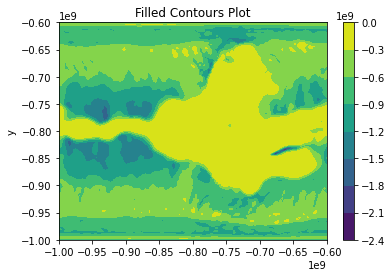

In [25]:
# first grid of (288, 128, 128)
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
# the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
z1 = dumps_ma[str(i0)].cache['coeff1'][0]

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
plt.show()

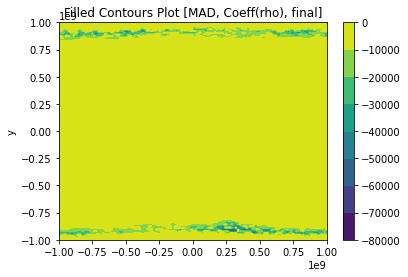

In [31]:
# mid grid
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
# the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
z1 = dumps_ma[str(i0)].cache['coeff1'][144]

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot [MAD, Coeff(rho), final]')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
plt.show()

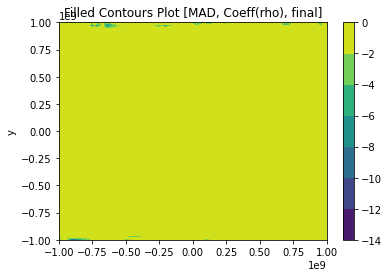

In [32]:
# last grid
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
# the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
z1 = dumps_ma[str(i0)].cache['coeff1'][287]

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot [MAD, Coeff(rho), final]')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
plt.show()

Try average value

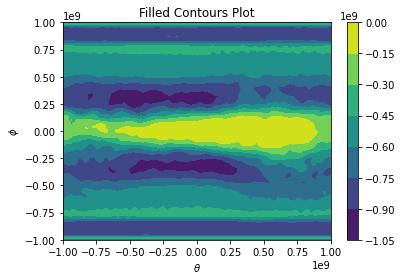

In [46]:
# theta_phi
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
# the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
z1 = dumps_ma[str(i0)].cache['avgcoeff1'][0]

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
plt.show()

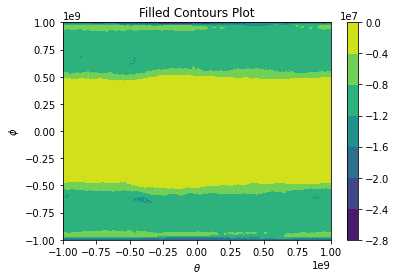

In [20]:
# theta_phi
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_ma[str(i0)].cache['avgcoeff1'][63]

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
plt.show()

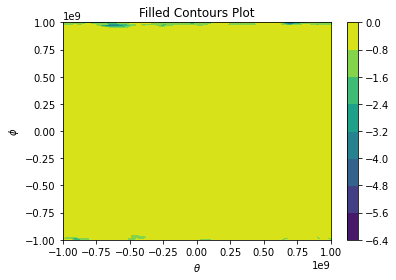

In [20]:
# theta_phi
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_ma[str(i0)].cache['avgcoeff1'][-1]

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
plt.show()

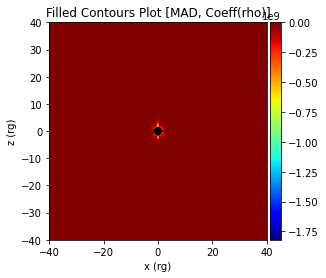

In [45]:
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
# the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
# z1 = dumps_ma[str(i0)].cache['coeff1'][:, 0, :]

fig,ax=plt.subplots(1,1)
pplt.plot_xz(ax, dumps_ma[str(i0)], 'coeff1')
pplt.overlay_contours(ax, dump, 'coeff1',  levels=[25, 50, 75], use_contourf=True)
ax.set_title('Filled Contours Plot [MAD, Coeff(rho)]')
ax.set_xlabel('x (rg)')
ax.set_ylabel('z (rg)')
plt.show()

need an average calculation?

Try and make a movable 3D contour plot in MatLab?

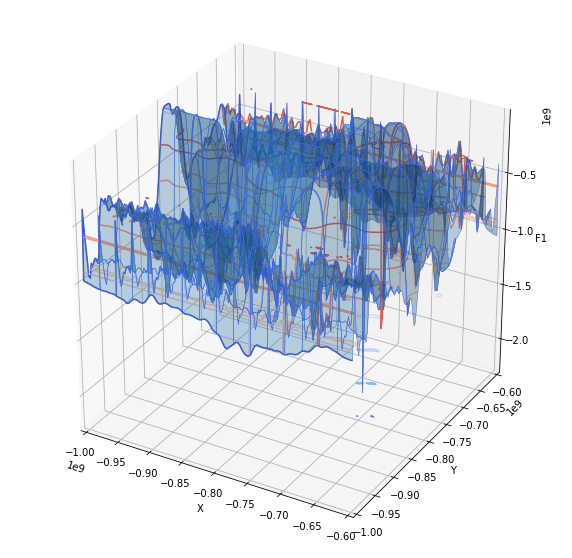

In [26]:
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_ma[str(i0)].cache['coeff1'][0]

plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, z1, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, z1, zdir='z', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='x', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='y', cmap='coolwarm')

ax.set(xlim=(-1e9, -6e8), ylim=(-1e9, -6e8), xlabel='X', ylabel='Y', zlabel='F1')

plt.show()

$F_{2}$

In [16]:
for dump in dumps_ma.values():
    F2(dump, R_high[0], R_low)

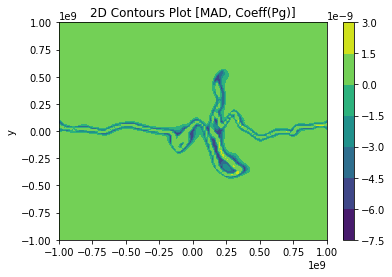

In [20]:
twoD_contour(dumps_ma, 'coeff2', '2D Contours Plot [MAD, Coeff(Pg)]')

In [17]:
Pg_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff2'])

finish average calculation.


In [18]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_ma_coeff_avg.values())))

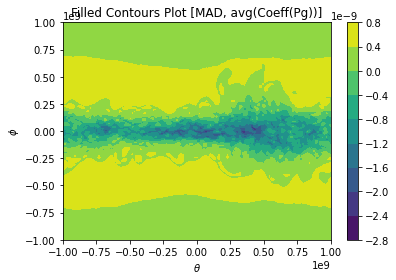

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]')

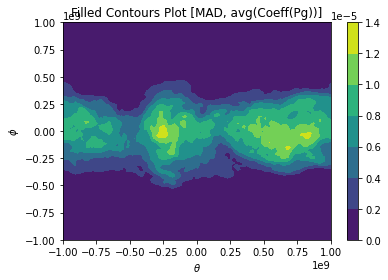

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=63)

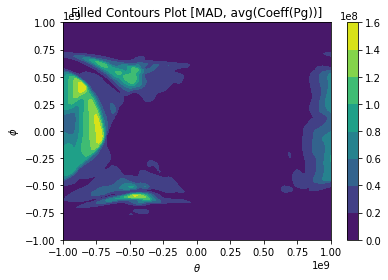

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=-1)

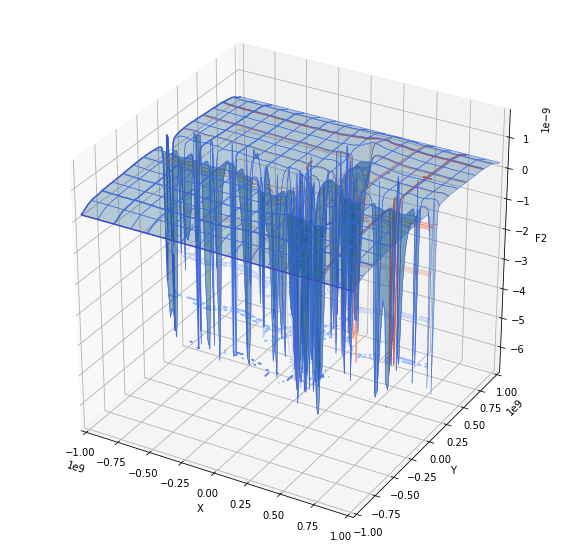

In [21]:
threeD_contour(dumps_ma, 'coeff2', '3D Contours Plot [MAD, Coeff(Pg)]', 'F2')

$F_{3}$

In [16]:
for dump in dumps_ma.values():
    F3(dump, R_high[0], R_low)

In [17]:
print(dumps_ma[str(i0)].cache['coeff3'][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


??? why all zeros

In [18]:
print(dumps_ma[str(i0)].cache['coeff3'][287])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
twoD_contour(dumps_ma, 2e-10, 2.6e-10, 'coeff3', 'Filled Contours Plot [MAD, Coeff(P_mag)]')

### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [17]:
for dump in dumps_ma.values():
    F1(dump, R_high[3], R_low)

In [19]:
print(dumps_ma[str(i0)].cache['coeff1'].shape)

(288, 128, 128)


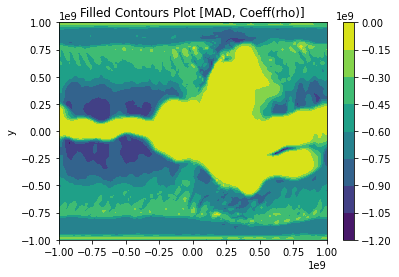

In [20]:
twoD_contour(dumps_ma, 'coeff1', 'Filled Contours Plot [MAD, Coeff(rho)]')

In [18]:
rho_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_ma_coeff_avg.values())))

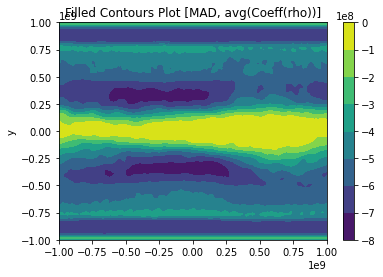

In [20]:
twoD_contour(dumps_ma, 'avgcoeff1', 'Filled Contours Plot [MAD, avg(Coeff(rho))]')

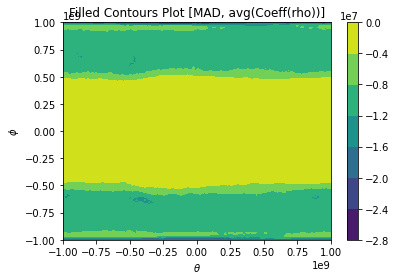

In [20]:
twoD_contour(dumps_ma, 'avgcoeff1', 'Filled Contours Plot [MAD, avg(Coeff(rho))]', idx=63)

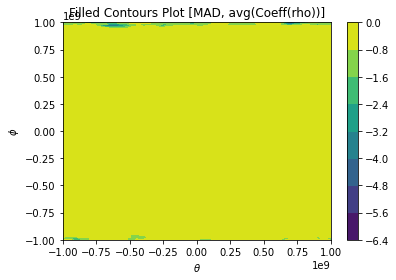

In [22]:
twoD_contour(dumps_ma, 'avgcoeff1', 'Filled Contours Plot [MAD, avg(Coeff(rho))]', idx=-1)

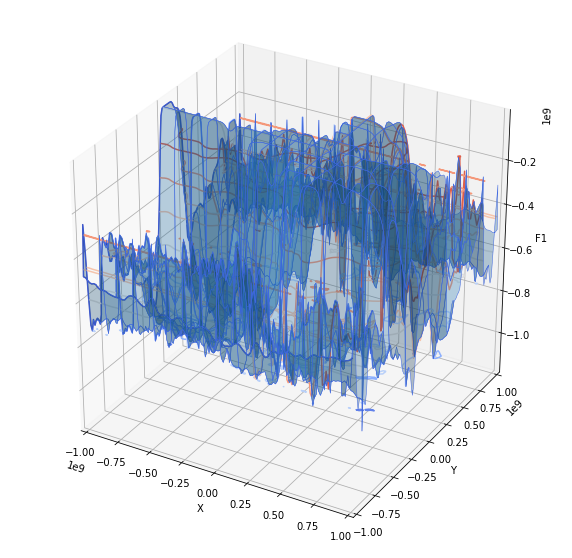

In [21]:
threeD_contour(dumps_ma, 'coeff1', '3D Contours Plot [MAD, Coeff(rho)]', 'F1')

$F_{2}$

In [37]:
for dump in dumps_ma.values():
    F2(dump, R_high[0], R_low)

In [19]:
print(dumps_ma[str(i0)].cache['coeff2'][0])

[[2.11745250e-10 2.11585002e-10 2.11800973e-10 ... 2.12718824e-10
  2.12595850e-10 2.12170054e-10]
 [2.26586448e-10 2.27518587e-10 2.27672536e-10 ... 2.27015427e-10
  2.25695148e-10 2.25696738e-10]
 [2.58961508e-10 2.59376199e-10 2.59484699e-10 ... 2.56730798e-10
  2.57167936e-10 2.57954990e-10]
 ...
 [2.55281846e-10 2.53672351e-10 2.53815383e-10 ... 2.54812947e-10
  2.55513497e-10 2.56096864e-10]
 [2.30954343e-10 2.30653857e-10 2.31007327e-10 ... 2.30190073e-10
  2.30749363e-10 2.31291749e-10]
 [2.16493775e-10 2.17183127e-10 2.17859700e-10 ... 2.16664656e-10
  2.16555424e-10 2.16157569e-10]]


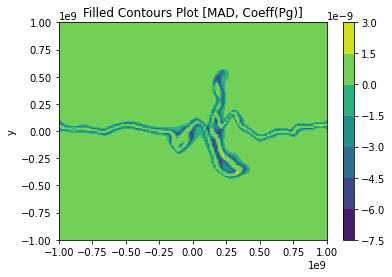

In [20]:
twoD_contour(dumps_ma, 'coeff2', 'Filled Contours Plot [MAD, Coeff(Pg)]')

In [38]:
Pg_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff2'])

finish average calculation.


In [39]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_ma_coeff_avg.values())))

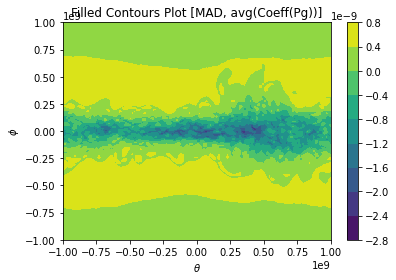

In [20]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]')

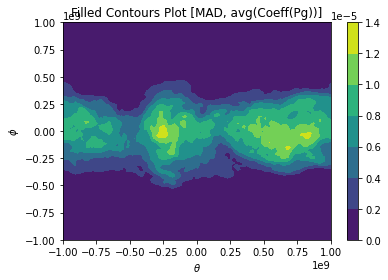

In [40]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=63)

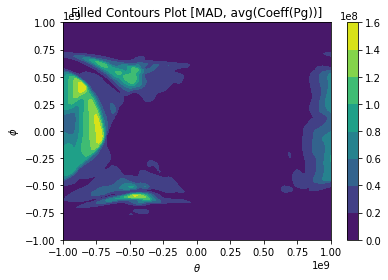

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=-1)

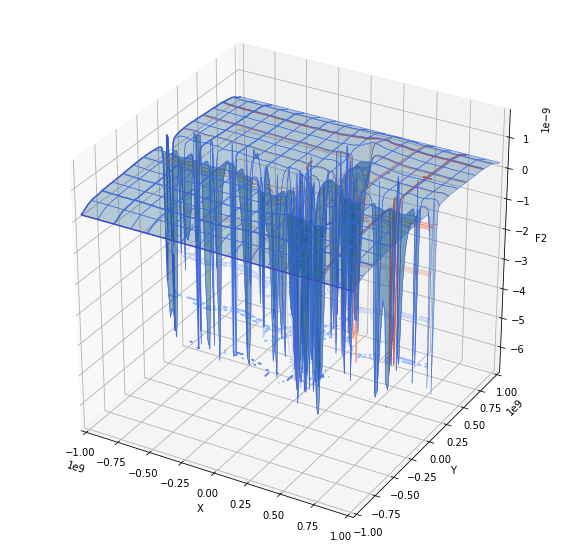

In [21]:
threeD_contour(dumps_ma, 'coeff2', '3D Contours Plot [MAD, Coeff(Pg)]', 'F2')

$F_{3}$

In [ ]:
for dump in dumps_ma.values():
    F3(dump, R_high[0], R_low)

In [ ]:
print(dumps_ma[str(i0)].cache['coeff2'][0])

In [ ]:
twoD_contour(dumps_ma, 'coeff3', 'Filled Contours Plot [MAD, Coeff(Pg)]')

### SANE

In [16]:
for dump in dumps_sa.values():
    dump['RHO']

$F_{1}$

In [17]:
for dump in dumps_sa.values():
    F1(dump, R_high[0], R_low)

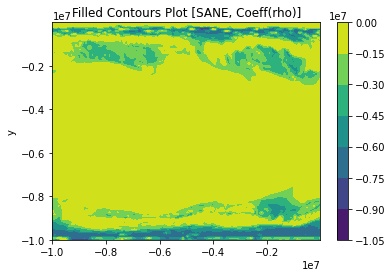

In [19]:
N = 128
x = np.linspace(-1e7, -1e3, N)
y = np.linspace(-1e7, -1e3, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_sa[str(i0)].cache['coeff1'][0]

fig, ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot [SANE, Coeff(rho)]')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
plt.show()

In [18]:
rho_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_sa_coeff_avg.values())))

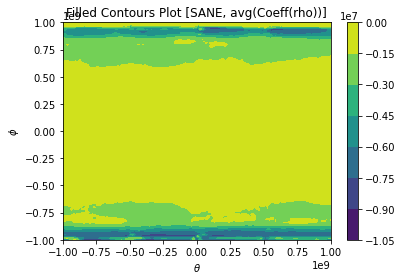

In [21]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]')

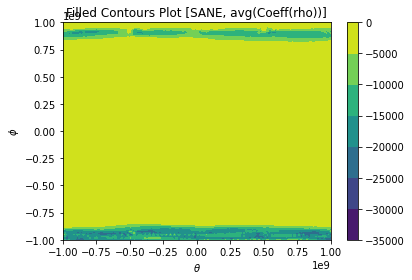

In [20]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=63)

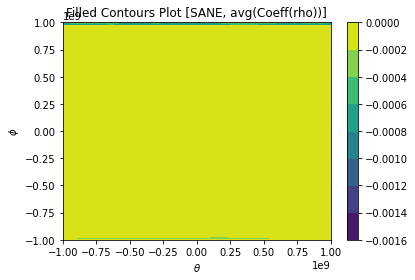

In [21]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=-1)

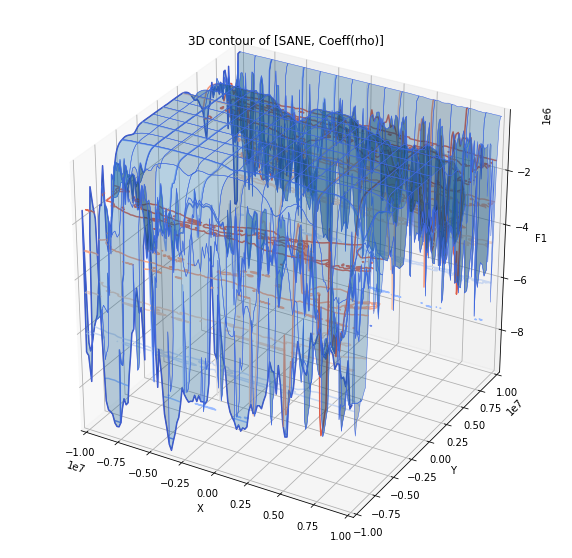

In [21]:
N = 128
x = np.linspace(-1e7, 1e7, N)
y = np.linspace(-1e7, 1e7, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_sa[str(i0)].cache['coeff1'][0]

plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, z1, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, z1, zdir='z', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='x', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='y', cmap='coolwarm')

ax.set(xlim=(-1e7, 1e7), ylim=(-1e7, 1e7), xlabel='X', ylabel='Y', zlabel='F1')

plt.title('3D contour of [SANE, Coeff(rho)]')
plt.show()

$F_{2}$

In [17]:
for dump in dumps_sa.values():
    F2(dump, R_high[0], R_low)

In [19]:
print(dumps_sa[str(i0)].cache['coeff2'][0])

[[6.34638509e-09 6.50515238e-09 5.65474588e-09 ... 4.49787574e-09
  6.11532647e-09 5.32721539e-09]
 [4.20821136e-09 4.30628679e-09 4.18790744e-09 ... 4.88396138e-09
  4.77975336e-09 4.45907934e-09]
 [6.64793379e-09 6.58375322e-09 6.45099575e-09 ... 6.74601598e-09
  6.61272181e-09 6.59551621e-09]
 ...
 [1.01596294e-08 1.03046432e-06 1.58948173e-07 ... 2.88095888e-07
  1.55007809e-07 9.05885259e-07]
 [5.44986485e-04 1.02613019e-02 1.43202601e-01 ... 1.27826907e+00
  3.20357587e+00 8.45960716e+00]
 [1.51626789e-07 1.52859755e-03 5.90954807e-04 ... 8.09814455e-07
  5.17061486e-05 2.22696646e-04]]


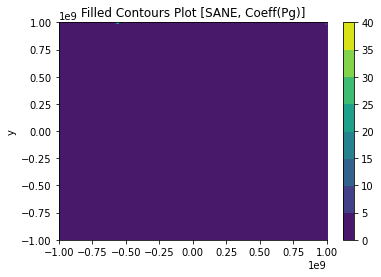

In [20]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]')

In [18]:
Pg_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff2'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_sa_coeff_avg.values())))

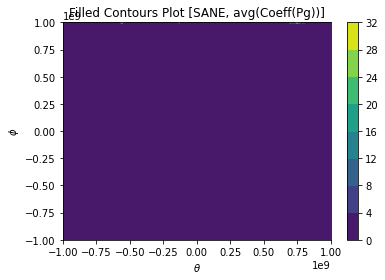

In [20]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Filled Contours Plot [SANE, avg(Coeff(Pg))]')

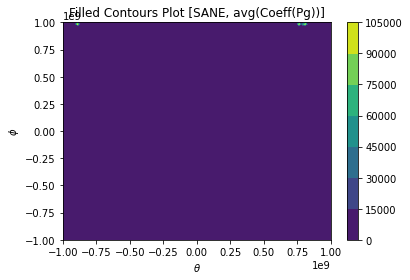

In [20]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Filled Contours Plot [SANE, avg(Coeff(Pg))]', idx=63)

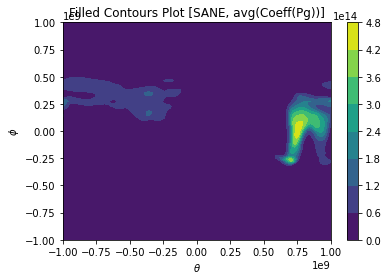

In [22]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Filled Contours Plot [SANE, avg(Coeff(Pg))]', idx=-1)

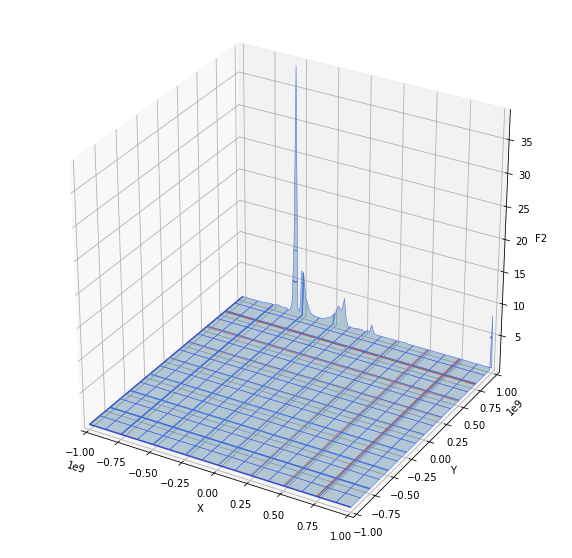

In [21]:
threeD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', 'F2')

$F_{3}$

In [16]:
for dump in dumps_sa.values():
    F3(dump, R_high[0], R_low)

In [17]:
print(dumps_sa[str(i0)].cache['coeff3'][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
twoD_contour(dumps_sa, 'coeff3', 'Filled Contours Plot [SANE, Coeff(Pmag)]')

### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [16]:
for dump in dumps_sa.values():
    F1(dump, R_high[3], R_low)

In [20]:
print(dumps_sa[str(i0)].cache['coeff1'][0])

[[-6.70223005e+06 -6.80409963e+06 -7.76068145e+06 ... -4.14850112e+06
  -5.85223418e+06 -5.68430839e+06]
 [-1.56396899e+06 -1.72943606e+06 -1.41764789e+06 ... -3.92849842e+06
  -3.57273944e+06 -2.21756276e+06]
 [-6.42865247e+06 -6.48266542e+06 -6.54511103e+06 ... -6.35741270e+06
  -6.43542691e+06 -6.44453834e+06]
 ...
 [-1.37515233e+04 -7.60528273e+04 -3.95816543e+05 ... -2.56019935e+05
  -9.73976209e+04 -2.00244015e+05]
 [-1.58975134e+01 -7.68875985e+01 -1.80350713e+02 ... -2.52645197e+02
  -1.23372249e+02 -4.42638178e+01]
 [-1.15381804e+03 -6.98380490e+03 -5.73765764e+03 ... -2.89484829e+03
  -7.38251721e+03 -9.20473864e+03]]


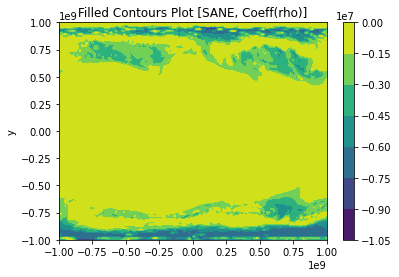

In [20]:
twoD_contour(dumps_sa,'coeff1','Filled Contours Plot [SANE, Coeff(rho)]')

In [17]:
rho_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff1'])

finish average calculation.


In [18]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_sa_coeff_avg.values())))

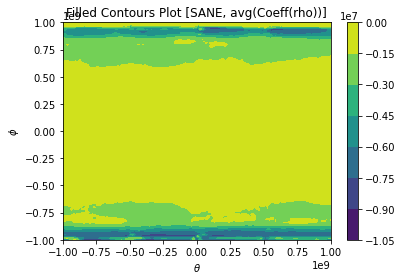

In [21]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]')

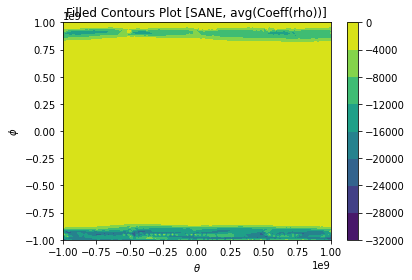

In [22]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=64)

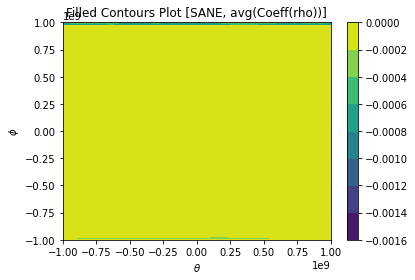

In [23]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=-1)

$F_{2}$

In [17]:
for dump in dumps_sa.values():
    F2(dump, R_high[3], R_low)

In [18]:
print(dumps_sa[str(i0)].cache['coeff2'][0])

[[6.08446100e-09 6.23279578e-09 5.47045871e-09 ... 4.44628581e-09
  5.88111466e-09 5.18590444e-09]
 [4.18941927e-09 4.27609932e-09 4.17125270e-09 ... 4.79141787e-09
  4.69632002e-09 4.41121238e-09]
 [6.38240073e-09 6.32402559e-09 6.20741013e-09 ... 6.47093913e-09
  6.35219834e-09 6.33697003e-09]
 ...
 [1.01420278e-08 9.81291196e-07 1.50541003e-07 ... 2.75158575e-07
  1.52392578e-07 8.34668961e-07]
 [5.26421197e-04 5.50877828e-03 9.16635059e-03 ... 1.11326010e-02
  2.45104511e-02 6.49066142e-02]
 [1.51514315e-07 3.32524232e-04 2.05363694e-04 ... 8.06333023e-07
  4.46265682e-05 1.37410849e-04]]


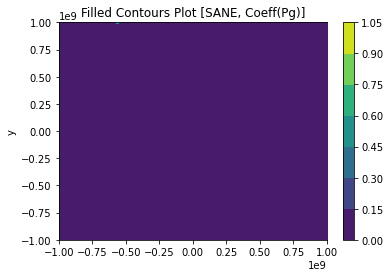

In [18]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]')

In [18]:
Pg_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff2'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_sa_coeff_avg.values())))

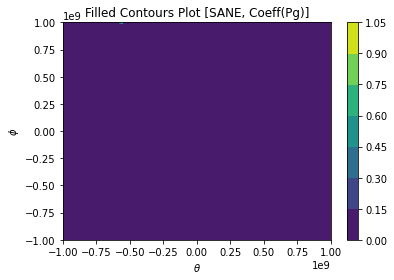

In [25]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', idx=0)

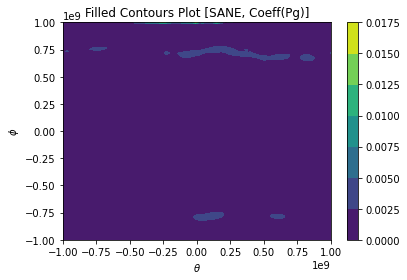

In [26]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', idx=63)

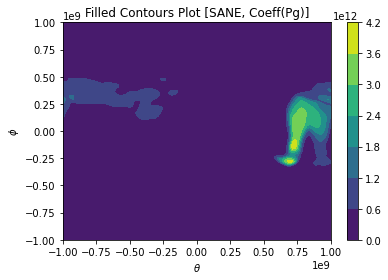

In [27]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', idx=-1)

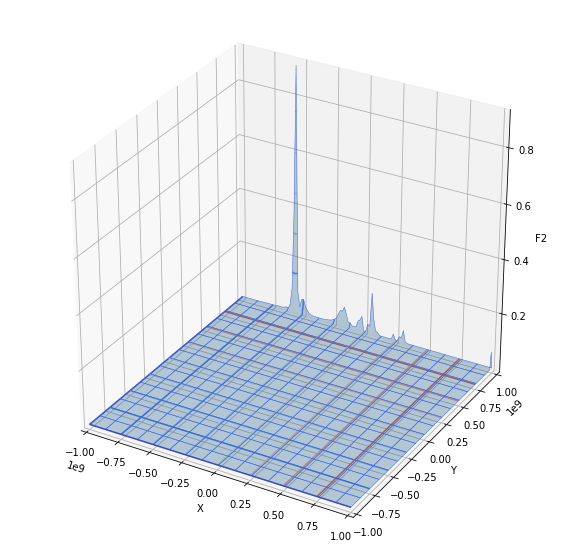

In [24]:
threeD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', 'F2')